## Classifying Songs into Happy and Sad

#### By Ryan Moerer

In [52]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from secret import client_id, client_secret # import my Spotify API credentials
np.random.seed(42)

## Data Collection

In [53]:
# Spotify API authorization
credentials = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

sp = spotipy.Spotify(auth_manager=credentials)

In [58]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def get_tracks(query):
    # get 50 playlists for query
    playlist_res = sp.search(query, type='playlist', limit=50)
    playlists = {}
    for playlist in playlist_res['playlists']['items']:
        playlists[playlist['name']] = playlist['id']
    # get all tracks into df
    all_tracks = []
    for name, id in playlists.items():
        ofst = 0
        while True:
            response = sp.playlist_tracks(id, offset=ofst, limit=100)
            for track in response['items']:
                if track['track']:
                    all_tracks.append({'playlist_name': name,'playlist_id': id,'name': track['track']['name'],'album_name': track['track']['album']['name'],
                        'artist': track['track']['artists'][0]['name'],'id': track['track']['id'],'popularity': track['track']['popularity'],'explicit': track['track']['explicit']
                    })
            ofst += 100
            if not response['next']:
                break
    tracks_df = pd.DataFrame(all_tracks).drop_duplicates(subset=['id'])
    # get all features into df
    features = []
    for chunk in chunker(tracks_df['id'].tolist(), 100):
        features.extend(sp.audio_features([id for id in chunk if id]))
    features_df = pd.DataFrame([feature for feature in features if feature]).drop(columns=["uri","track_href","analysis_url","type"])
    return pd.merge(tracks_df, features_df, left_on="id", right_on="id", how="inner")

In [78]:
# create dataframe
# commented out as to not accidentally overwrite dataset
#happy_df = get_tracks("happy songs")
#sad_df = get_tracks("sad songs")
#happy_df['y'] = 1
#sad_df['y'] = 0
#data = pd.concat([happy_df, sad_df])
#data = data.groupby('id').filter(lambda x: len(x)<2) # in case some songs are classified as happy and sad
#g = data.groupby('y')
#data = g.apply(lambda x: x.sample(g.size().min(), random_state=3)).reset_index(drop=True)
#data.to_csv("data/songs_data.csv")
#data

,playlist_name,playlist_id,name,album_name,artist,id,popularity,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,y
0,Sad Tamil Songs 🥀,6ybCs40CUSVISYNRoqtQAZ,Veshangalil Poiyillai - Additional Song,Remo Special (Original Background Score + Addi...,Anirudh Ravichander,1Uxuizxwr1ODjC9RTiisz2,43,False,0.188,0.200,...,0,0.0321,0.84900,0.001760,0.1130,0.104,87.879,64286,4,0
1,Sad Hindi Melodies,37i9dQZF1DXdFesNN9TzXT,Saazish,Dhindora,Rekha Bhardwaj,1lUiAVWYybAHIznMWDS3XQ,59,False,0.543,0.415,...,1,0.0308,0.75700,0.000626,0.0903,0.281,80.008,280063,4,0
2,sad songs to cry to,70VaOHyjpsWcmA4gxosExZ,free love - dream edit,nswy: dream edits,HONNE,3HAsf0o0TJY9WL4zKCzE3u,54,False,0.670,0.220,...,1,0.0422,0.93900,0.000076,0.1110,0.139,119.604,249945,4,0
3,Sad Songs 😢,7ABD15iASBIpPP5uJ5awvq,Dust On The Ground,Flaws,Bombay Bicycle Club,2SbIONplUQ0BvXyRgGDgCz,0,False,0.605,0.319,...,1,0.0306,0.75700,0.002370,0.1160,0.273,109.599,243752,4,0
4,Sad Songs 😢,7ABD15iASBIpPP5uJ5awvq,Should Have Known Better,Carrie & Lowell,Sufjan Stevens,5I6y1KWmUoV5YCaIEcs1qs,33,False,0.571,0.172,...,1,0.0318,0.97900,0.275000,0.1240,0.297,90.972,307698,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,happy songs 🌻💛✨,7dIkcjjWjQvifEpu4UE80K,You Time,You Time,Scotty McCreery,0pJalGEYsRikSogLkXU6KV,63,False,0.550,0.767,...,1,0.0248,0.00141,0.000003,0.1430,0.601,104.016,192027,3,1
8906,Happy Songs | Wit & Delight,7kPEnbzzu3DvjeeY9KhSeO,You Send Me,Aretha Now,Aretha Franklin,4VijLEUxHEzbWKYL5u9wuN,62,False,0.512,0.303,...,1,0.0374,0.57000,0.000000,0.0803,0.629,102.908,149627,4,1
8907,Happy songs for gays & dads named joe,1VktPz6bl3kwuT6CHXaklA,Bennie And The Jets - Remastered 2014,Goodbye Yellow Brick Road (Remastered),Elton John,5Wj1rJnCLpMHdLaxsFtJLs,74,False,0.665,0.673,...,1,0.0493,0.25900,0.000008,0.4970,0.779,132.642,322549,4,1
8908,Happy Rock Songs,2BumzROvyilNPyczjghkba,Two Princes,Pocket Full Of Kryptonite (Anniversary Edition),Spin Doctors,0cuq829zRNq4AEdmDJA4aw,67,False,0.544,0.905,...,1,0.0646,0.00165,0.000002,0.0532,0.825,103.594,256947,4,1


## Data Cleaning and Preprocessing

In [88]:
data = pd.read_csv("data/songs_data.csv", index_col=0)
data

In [91]:
# create training and testing sets
X = data.iloc[:,7:-1].drop(columns=['time_signature'])
X = pd.get_dummies(X, columns=['key'])
y = data['y']
X_features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=12)

# Standardize training and testing sets
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [92]:
# Example of cleaned data
X_train.iloc[0]

explicit               False
danceability           0.545
energy                  0.78
loudness              -4.867
mode                       0
speechiness           0.0436
acousticness          0.0309
instrumentalness    4.64e-05
liveness              0.0828
valence                0.458
tempo                125.014
duration_ms           255093
key_0                      0
key_1                      0
key_2                      0
key_3                      0
key_4                      0
key_5                      0
key_6                      0
key_7                      1
key_8                      0
key_9                      0
key_10                     0
key_11                     0
Name: 7762, dtype: object

## Visualizing the Data

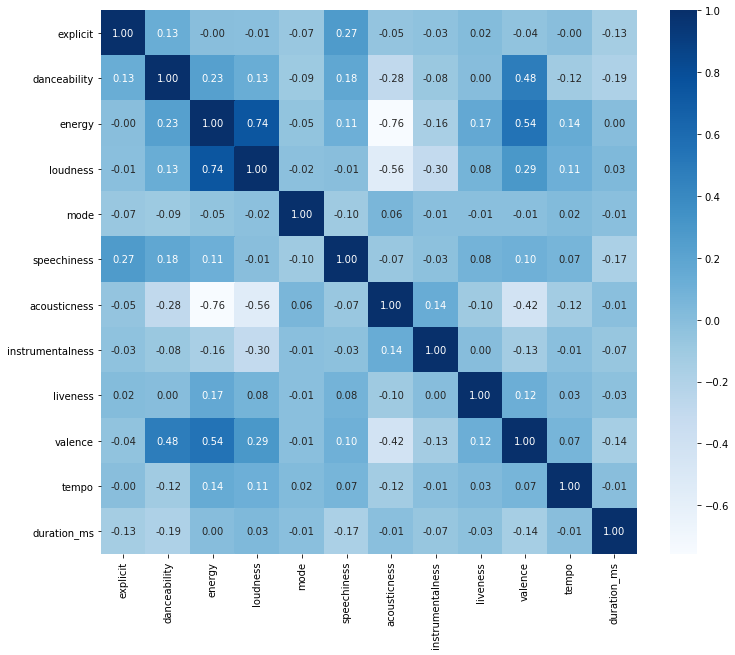

In [108]:
# Create correlation matrix plot
cols = ['key_' + str(i) for i in range(0,12)]
cols + ['mode','explicity']
corr_matrix = X_train.drop(columns=cols).corr()
heatmap_plot = sns.heatmap(corr_matrix, cmap="Blues", annot=True, fmt=".2f")
fig = heatmap_plot.get_figure()
fig.set_size_inches(12, 10)
fig.savefig("images/corr_mat.png")

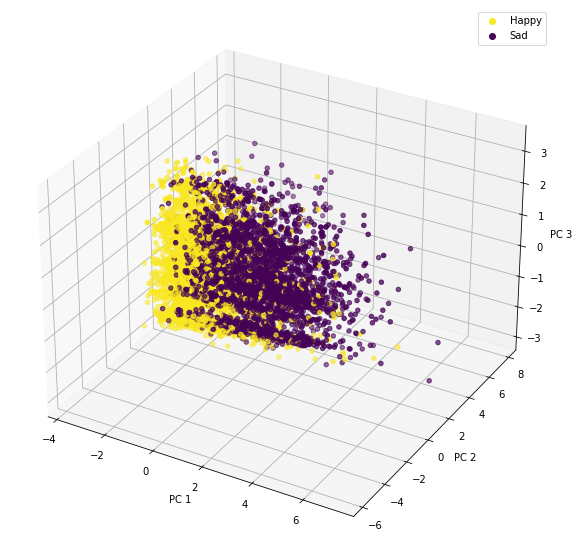

In [95]:
# PCA and PCA plot
pca = PCA(n_components=3, random_state=30)
pca_values = pca.fit_transform(X_train_scaled)

fig = plt.figure()
ax = plt.axes(projection='3d')

x = pca_values[:,0]
y = pca_values[:,1]
z = pca_values[:,2]

scatter1_proxy = plt.Line2D([0],[0], linestyle="none", marker = 'o', color='#F9E721')
scatter2_proxy = plt.Line2D([0],[0], linestyle="none", marker = 'o', color='#450256')

colors = {1: '#F9E721', 0: '#450256'}

ax.scatter(x,y,z, c = y_train.map(colors))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend([scatter1_proxy, scatter2_proxy], ['Happy', 'Sad'], numpoints = 1)
fig.set_size_inches(10,10)
plt.savefig("images/pca.png")

## KNN

In [109]:
# standardize the training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# create param grid
params = {'n_neighbors': list(range(1,51))}

# KNN classifier with Minkowski distance
knn = KNeighborsClassifier(weights='distance')

# grid search
knn_gridsearch = GridSearchCV(knn, param_grid=params, scoring='accuracy', cv=10)
knn_gridsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [110]:
# best training accuracy and params
knn_gridsearch.best_params_, knn_gridsearch.best_score_

({'n_neighbors': 42}, 0.8279651294398486)

## Logistic Regression

In [98]:
10**np.linspace(-4,5,20)

array([1.00000000e-04, 2.97635144e-04, 8.85866790e-04, 2.63665090e-03,
       7.84759970e-03, 2.33572147e-02, 6.95192796e-02, 2.06913808e-01,
       6.15848211e-01, 1.83298071e+00, 5.45559478e+00, 1.62377674e+01,
       4.83293024e+01, 1.43844989e+02, 4.28133240e+02, 1.27427499e+03,
       3.79269019e+03, 1.12883789e+04, 3.35981829e+04, 1.00000000e+05])

In [111]:
# create param grid
params = {'C':10**np.linspace(-4,5,20)}

# Logistic Regression with l2 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# grid search
log_gridsearch = GridSearchCV(log_reg, params, scoring='accuracy', cv=10)
log_gridsearch.fit(X_train_scaled, y_train)

# best params/best cross-validated accuracy
log_gridsearch.best_params_, log_gridsearch.best_score_

({'C': 0.023357214690901212}, 0.8346979565378442)

In [112]:
pd.Series(log_gridsearch.best_estimator_.coef_[0], index=X_features)

explicit           -0.328234
danceability        0.137185
energy              0.840765
loudness           -0.323958
mode                0.162042
speechiness        -0.075604
acousticness       -0.557517
instrumentalness    0.000000
liveness            0.018762
valence             1.233907
tempo               0.000000
duration_ms        -0.144970
key_0               0.000000
key_1               0.000000
key_2               0.000000
key_3              -0.024750
key_4               0.000000
key_5               0.000000
key_6               0.000000
key_7               0.000000
key_8              -0.038544
key_9               0.000000
key_10              0.000000
key_11              0.000000
dtype: float64

## Random Forests

In [101]:
# initialize RF model
rf_clf = RandomForestClassifier(random_state=42)

# fit model on training (not using standardized data for RF)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

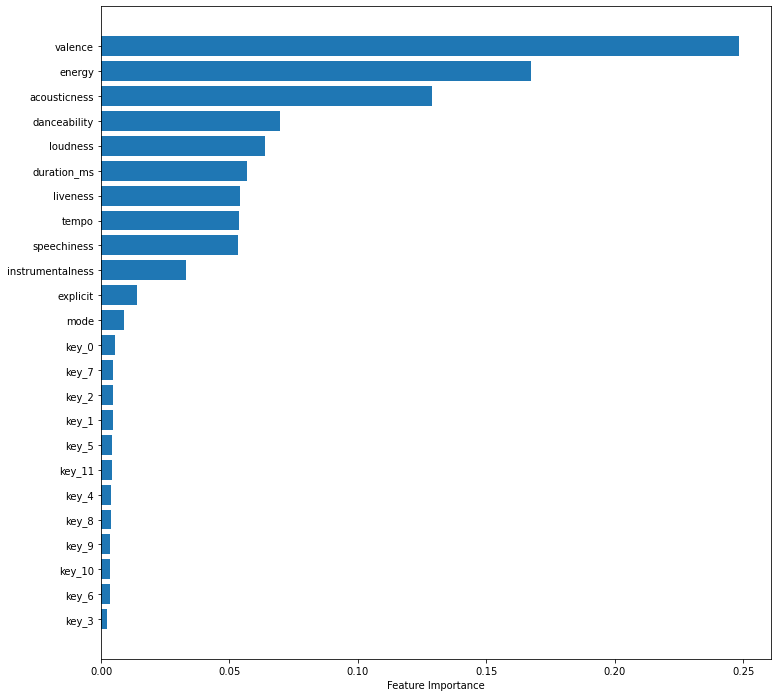

In [113]:
# create feature importance plot
feat_importances = rf_clf.feature_importances_
indices = np.argsort(feat_importances)

fig = plt.figure()
plt.barh(range(len(feat_importances)), feat_importances[indices])
plt.yticks(range(len(feat_importances)), labels=np.array(X_features)[indices])
plt.xlabel("Feature Importance")
fig.set_size_inches(12,12)
plt.savefig("images/feature_importance.png")
plt.show()

## Evaluating the Models

In [114]:
rf_preds = rf_clf.predict(X_test)
log_preds = log_gridsearch.predict(X_test_scaled)
knn_preds = knn_gridsearch.predict(X_test_scaled)

pd.DataFrame({
    'Precision': [precision_score(y_test, rf_preds),precision_score(y_test,log_preds),precision_score(y_test,knn_preds)],
    'Recall': [recall_score(y_test, rf_preds),recall_score(y_test,log_preds),recall_score(y_test,knn_preds)],
    'F1 Score': [f1_score(y_test, rf_preds),f1_score(y_test,log_preds),f1_score(y_test,knn_preds)],
    'Accuracy': [accuracy_score(y_test, rf_preds),accuracy_score(y_test,log_preds),accuracy_score(y_test,knn_preds)],
    }, 
    index=['Random Forest', 'KNN', 'LogisticRegression']).sort_values(by='Accuracy', ascending=False)

,Precision,Recall,F1 Score,Accuracy
Random Forest,0.836141,0.816754,0.826334,0.828283
LogisticRegression,0.818250,0.811518,0.814870,0.815563
KNN,0.820690,0.801047,0.810749,0.812944
